In [1]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [2]:
name = "underdamped_k12"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

12 True True True 1.0 16 [128, 128, 256]


### Problem definition

In [3]:
N = 5120
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [4]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [ ]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 60]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.8, 0.8, 0.8, 0.8, 0.8]
p_list = [10]
q = 3

### Numerical solver

In [6]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [7]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [8]:
NN_TL_solution.shape

(5120, 4, 2)

In [9]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.14826920870888172
zeta: 5, order: 1, mean error absolute: 0.12810360890462474
zeta: 5, order: 2, mean error absolute: 0.1320903592716686
zeta: 5, order: 3, mean error absolute: 0.13120120563800994
zeta: 5, order: 4, mean error absolute: 0.13141955883673448
zeta: 5, order: 5, mean error absolute: 0.13136124922428208
zeta: 5, order: 6, mean error absolute: 0.13137774314716202
zeta: 5, order: 7, mean error absolute: 0.13137288482382728
zeta: 5, order: 8, mean error absolute: 0.13137435744624879
zeta: 5, order: 9, mean error absolute: 0.1313739014746342


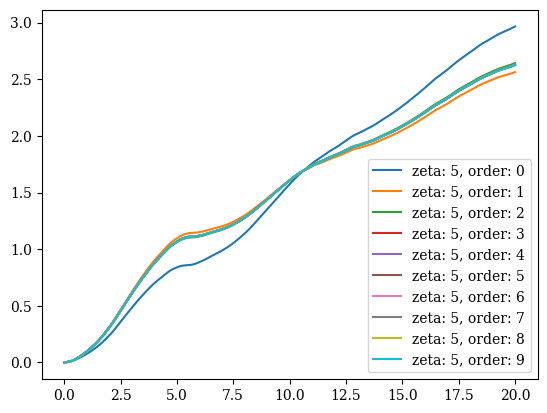

zeta: 10, order: 0, mean error absolute: 0.10204565096390028
zeta: 10, order: 1, mean error absolute: 0.11706799668463641
zeta: 10, order: 2, mean error absolute: 0.11594381390735434
zeta: 10, order: 3, mean error absolute: 0.1160489379501195
zeta: 10, order: 4, mean error absolute: 0.11603860719584143
zeta: 10, order: 5, mean error absolute: 0.1160396884777833
zeta: 10, order: 6, mean error absolute: 0.11603957042678999
zeta: 10, order: 7, mean error absolute: 0.11603958370367855
zeta: 10, order: 8, mean error absolute: 0.11603958217326851
zeta: 10, order: 9, mean error absolute: 0.11603958235340284


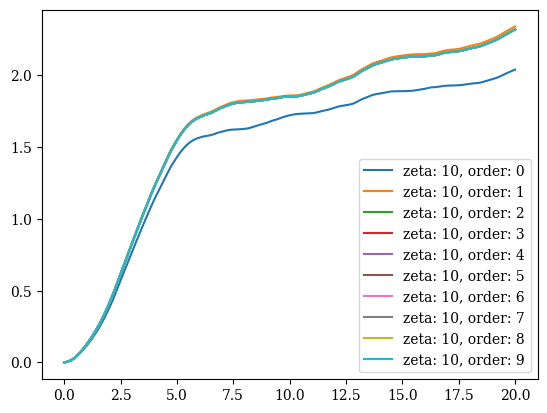

zeta: 30, order: 0, mean error absolute: 0.38617475231062076
zeta: 30, order: 1, mean error absolute: 0.39033636748063827
zeta: 30, order: 2, mean error absolute: 0.39025582519015234
zeta: 30, order: 3, mean error absolute: 0.3902568987978866
zeta: 30, order: 4, mean error absolute: 0.3902568904637256
zeta: 30, order: 5, mean error absolute: 0.3902568902576073
zeta: 30, order: 6, mean error absolute: 0.39025689027126453
zeta: 30, order: 7, mean error absolute: 0.39025689027077226
zeta: 30, order: 8, mean error absolute: 0.3902568902707862
zeta: 30, order: 9, mean error absolute: 0.3902568902707858


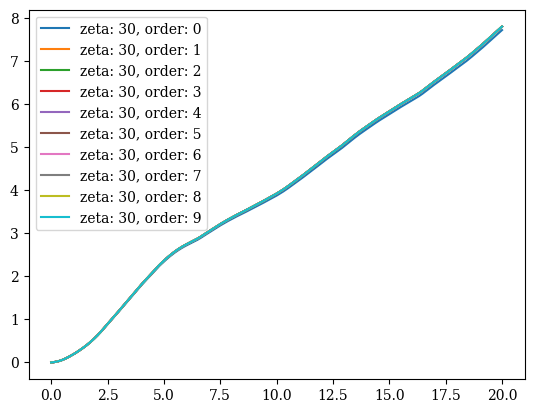

zeta: 60, order: 0, mean error absolute: 0.5120788008976683
zeta: 60, order: 1, mean error absolute: 0.5134817295758476
zeta: 60, order: 2, mean error absolute: 0.5134696114311839
zeta: 60, order: 3, mean error absolute: 0.5134696669594778
zeta: 60, order: 4, mean error absolute: 0.513469666885336
zeta: 60, order: 5, mean error absolute: 0.513469666882321
zeta: 60, order: 6, mean error absolute: 0.5134696668823997
zeta: 60, order: 7, mean error absolute: 0.5134696668823983
zeta: 60, order: 8, mean error absolute: 0.5134696668823983
zeta: 60, order: 9, mean error absolute: 0.5134696668823983


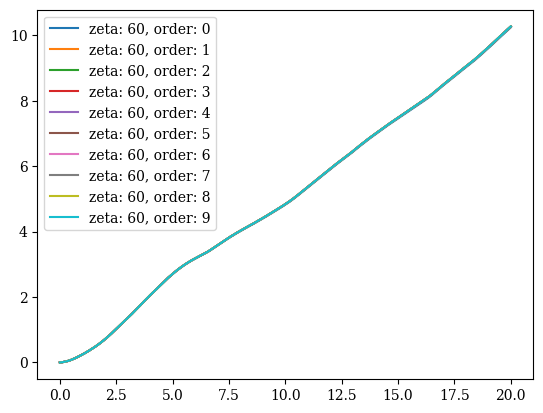

In [10]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

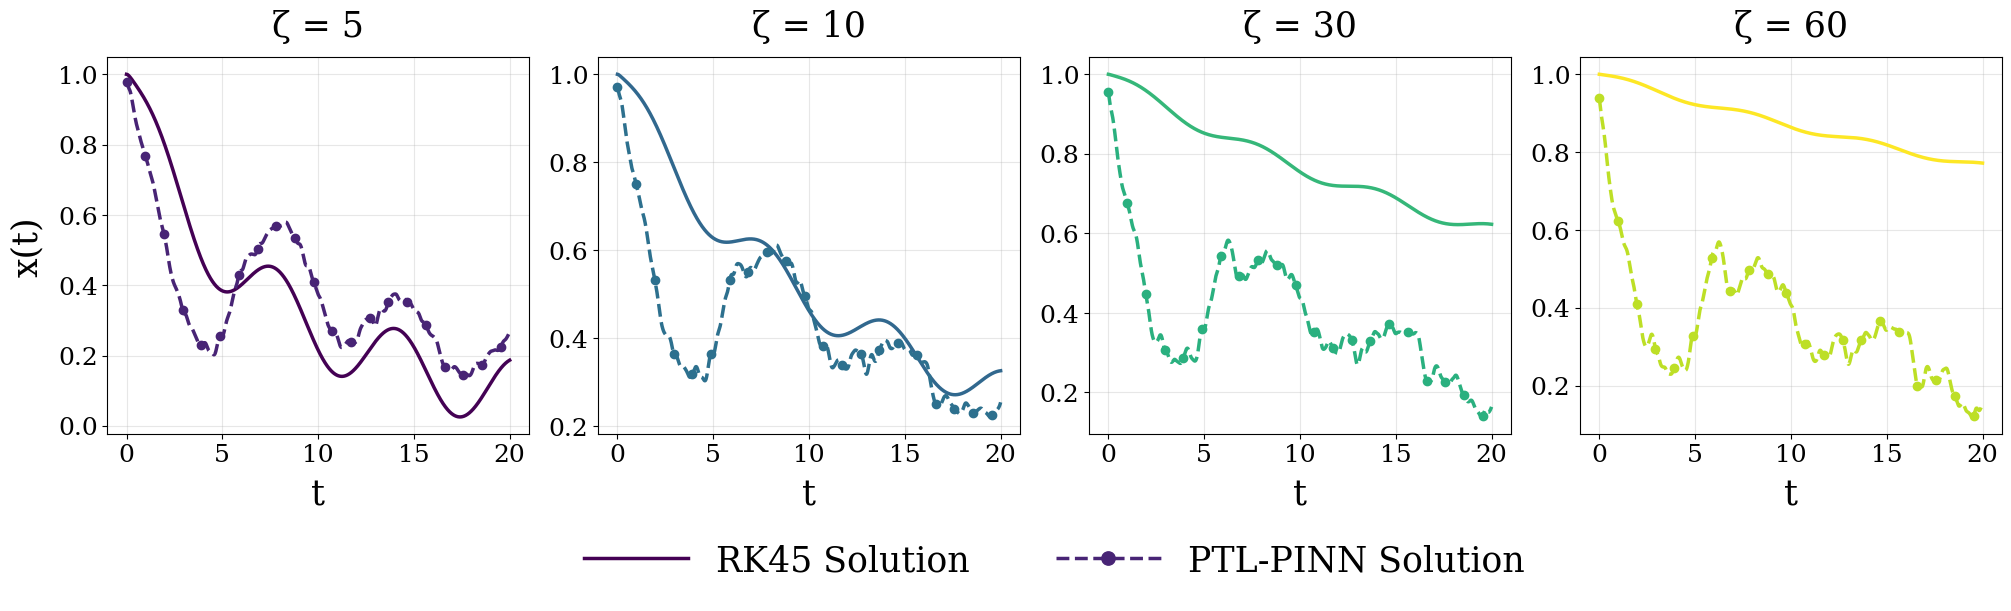

In [11]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


zeta: 5, mean Error: 1.314e-01
zeta: 10, mean Error: 1.160e-01
zeta: 30, mean Error: 3.903e-01
zeta: 60, mean Error: 5.135e-01


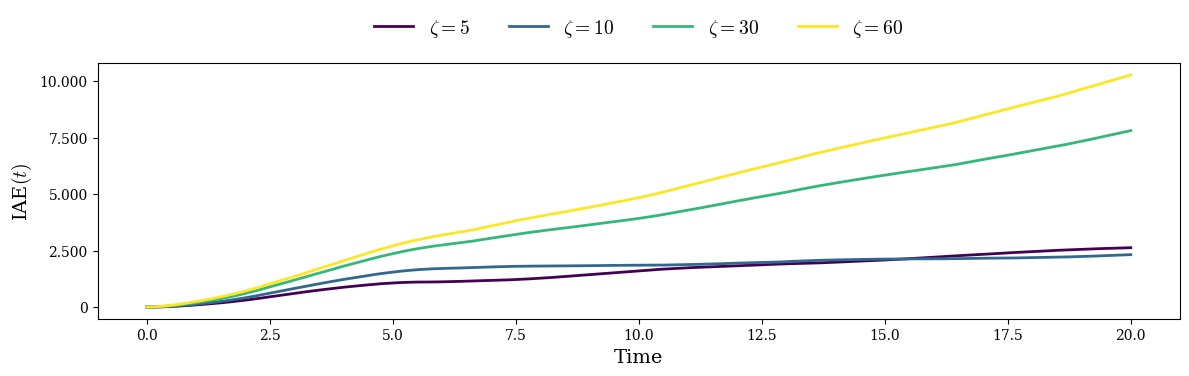

In [12]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_list)